# Metric Analysis for Rewiring Techniques

## Import utils

In [1]:
import os
import pygsheets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re


## Google API Setup

In [2]:
# Set the env var inside the notebook
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/alexandre/Documents/API/l65-gdl-dfbb4fdd8c94.json" # CHANGE THIS PATH
#Alternate path
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/cpaitken/Downloads/l65-mini-project-2780a4e77a2d.json" # CHANGE THIS PATH


client = pygsheets.authorize(service_account_file=os.environ["GOOGLE_APPLICATION_CREDENTIALS"])
print(client.spreadsheet_titles)


<bound method Client.spreadsheet_titles of <pygsheets.client.Client object at 0x1577d1710>>


Open the google sheet

In [3]:
# Open the Google Sheet with ID. The ID is the part of the url between the "/d/" and the "/edit"
SHEET_ID = "1iGEXfqWMPuTauYstnAYd16mc3medq7tubY_PT3_GeNY"
spreadsheet = client.open_by_key(SHEET_ID)

Select the worksheet

In [4]:
worksheet = spreadsheet.worksheet_by_title("Unrewired")

Read data

## Metrics evaluation

In [5]:
worksheet_data_specific = spreadsheet.worksheet_by_title("Dataset_Specific")

df = worksheet_data_specific.get_as_df()


# Rename columns for clarity
df.columns = ["Dataset", "Metric"] + df.iloc[0, 2:].tolist()
df = df[1:].reset_index(drop=True)

# **Forward fill dataset names BEFORE filtering**
df["Dataset"] = df["Dataset"].replace("", np.nan)  # Convert empty strings to NaN
df["Dataset"] = df["Dataset"].fillna(method="ffill")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pygsheets/worksheet.py:1554: UserWarning: At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.
  warnings.warn('At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.')
/var/folders/vw/1sh30gx175312mgfglxh9j840000gn/T/ipykernel_89605/3489738204.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Dataset"] = df["Dataset"].fillna(method="ffill")


In [8]:

# Remove extra spaces and newlines
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

for col in df.columns[2:]:
    # Split on '±' to get two parts: mean and std.
    # expand=True returns a DataFrame with two columns
    mean_std = df[col].str.split('±', expand=True)
    
    # Rename those columns appropriately
    df[col + "_mean"] = mean_std[0]  # left side of ±
    df[col + "_std"] = mean_std[1]   # right side of ±

    # Convert them to numeric (float). You can handle errors with 'coerce' if needed.
    df[col + "_mean"] = pd.to_numeric(df[col + "_mean"], errors='coerce')
    df[col + "_std"]  = pd.to_numeric(df[col + "_std"], errors='coerce')

diameter_df = df[df["Metric"] == "Diameter"].copy()

# # Filter for Modularity
# modularity_df = df[df["Metric"] == "Modularity"].copy()

# # Forward fill dataset names in case they are missing after filtering
# modularity_df["Dataset"] = modularity_df["Dataset"].fillna(method="ffill")


# Extract mean and std columns
mean_cols = [c for c in diameter_df.columns if c.endswith("_mean")]
std_cols = [c.replace("_mean", "_std") for c in mean_cols]
rewiring_methods = [c.replace("_mean", "") for c in mean_cols]

# Convert columns to numeric, forcing errors to NaN for clean processing
for col in mean_cols + std_cols:
    diameter_df[col] = pd.to_numeric(diameter_df[col], errors='coerce')

# Drop rows that contains COLLAB
diameter_df = diameter_df[~diameter_df["Dataset"].str.contains("COLLAB")]

# Ensure all values are numeric
for col in mean_cols + std_cols:
    diameter_df[col] = pd.to_numeric(diameter_df[col], errors='coerce')

fig, ax = plt.subplots(figsize=(12, 6))

datasets = diameter_df["Dataset"].unique()
x = np.arange(len(datasets))  # Positions for dataset groups
bar_width = 0.1  # Width of each bar

# Plot each rewiring method
for i, rew in enumerate(rewiring_methods):
    means = [diameter_df[diameter_df["Dataset"] == ds][rew + "_mean"].values[0] for ds in datasets]
    stds = [diameter_df[diameter_df["Dataset"] == ds][rew + "_std"].values[0] for ds in datasets]

    # Compute bar positions
    x_pos = x + (i - len(rewiring_methods)/2) * bar_width + bar_width/2
    
    ax.bar(x_pos, means, yerr=stds, width=bar_width, label=rew, capsize=5)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45, ha="right")
ax.set_title("Diameter Across Datasets and Rewiring Techniques")
ax.set_xlabel("Dataset")
ax.set_ylabel("Diameter (mean ± std)")
ax.legend(title="Rewiring Method", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("effective resistance.png")

plt.show()

/var/folders/vw/1sh30gx175312mgfglxh9j840000gn/T/ipykernel_80992/2213419382.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


AttributeError: Can only use .str accessor with string values!

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pygsheets/worksheet.py:1554: UserWarning: At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.
  warnings.warn('At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.')
/var/folders/vw/1sh30gx175312mgfglxh9j840000gn/T/ipykernel_89605/2789863883.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Dataset"] = df["Dataset"].fillna(method="ffill")
/var/folders/vw/1sh30gx175312mgfglxh9j840000gn/T/ipykernel_89605/2789863883.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinsta

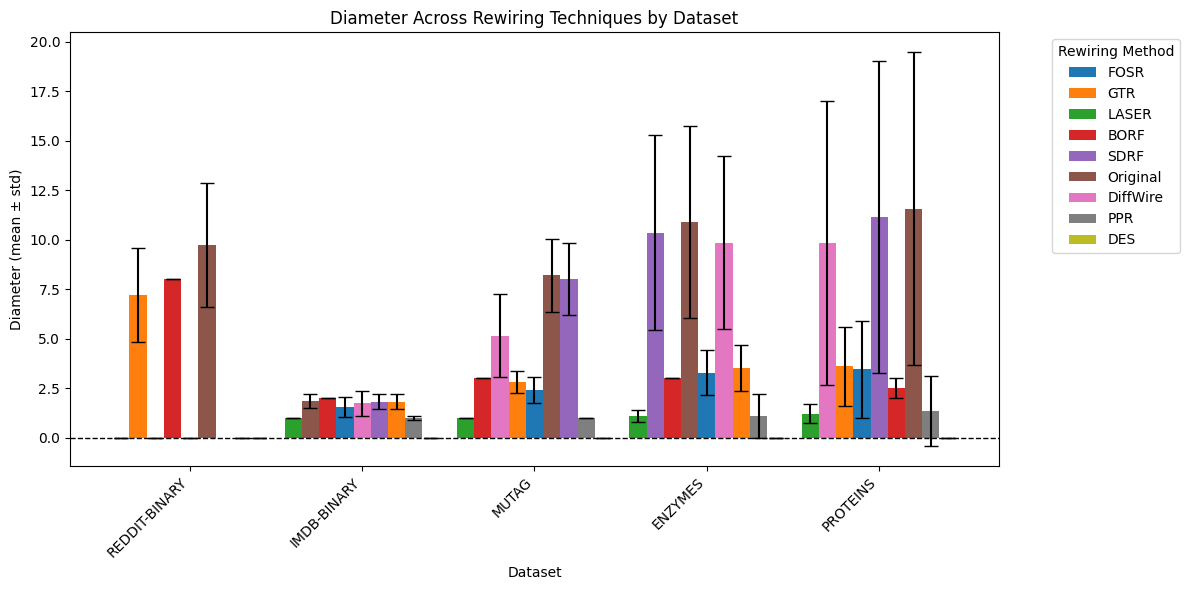

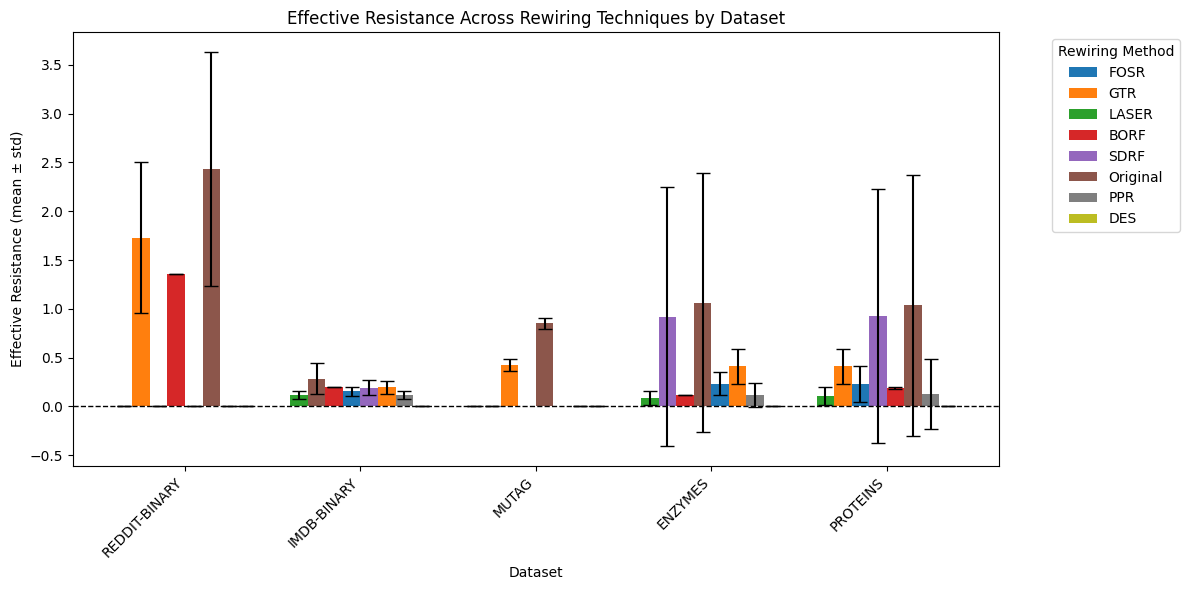

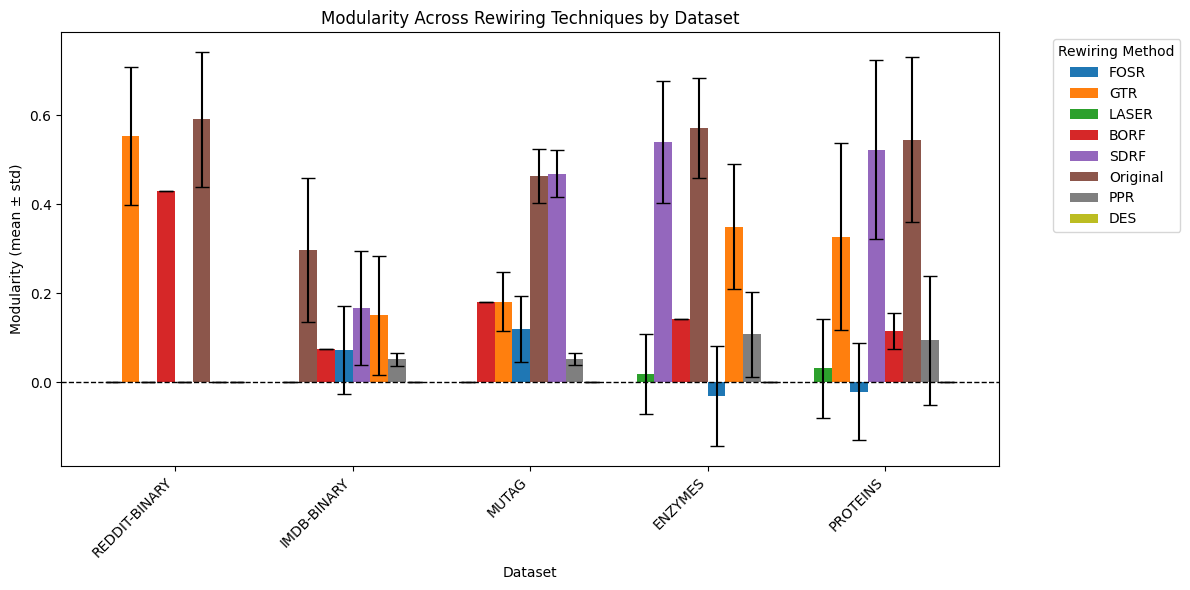

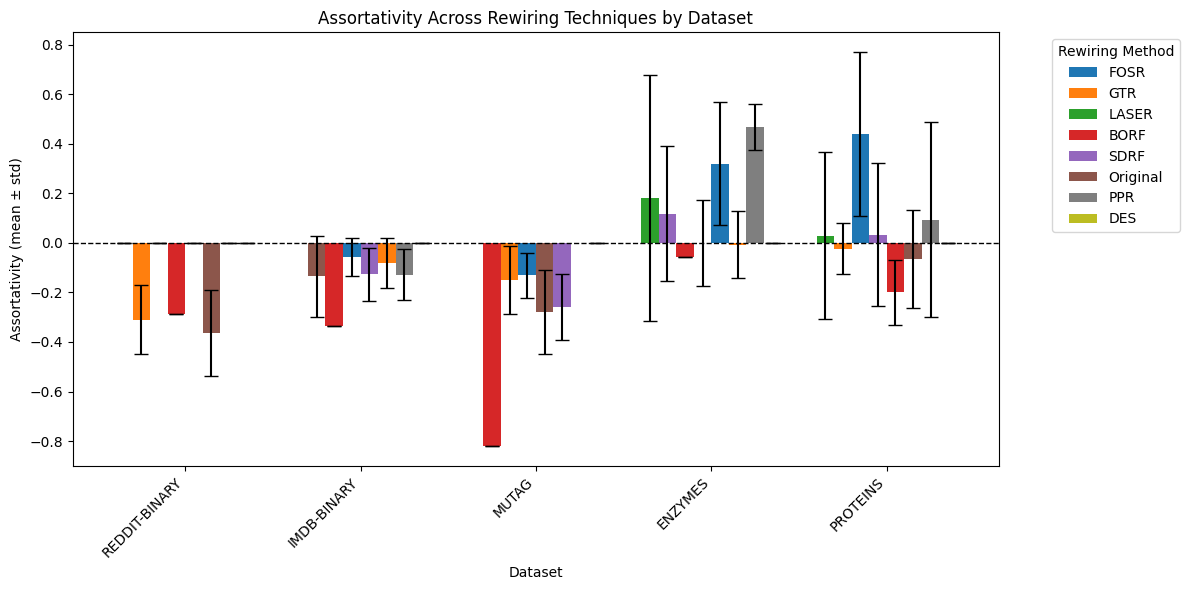

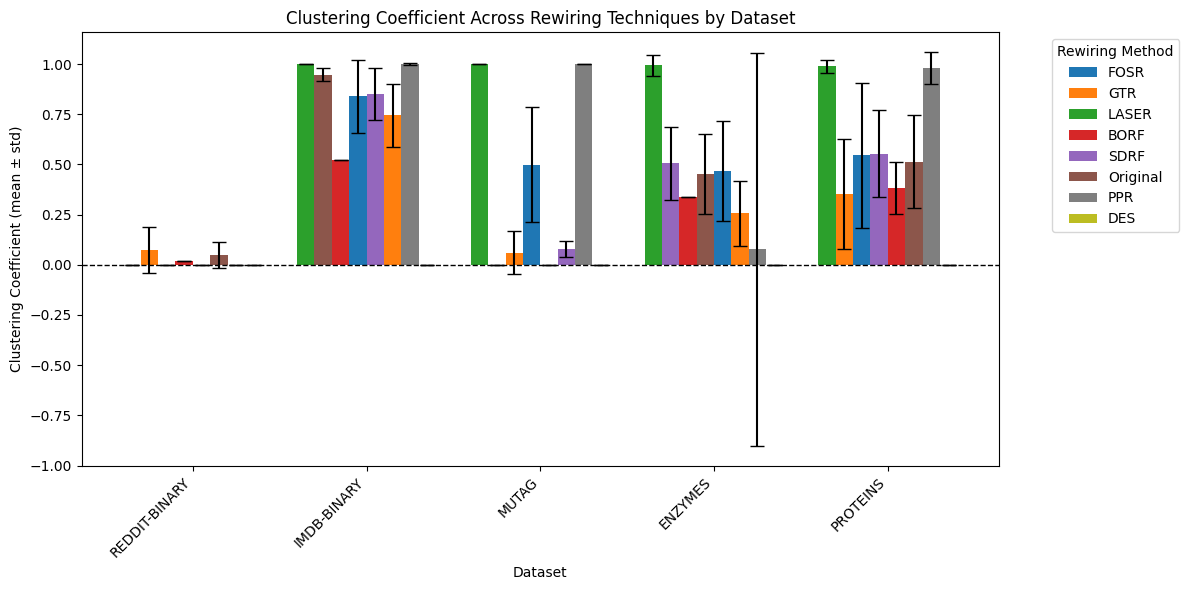

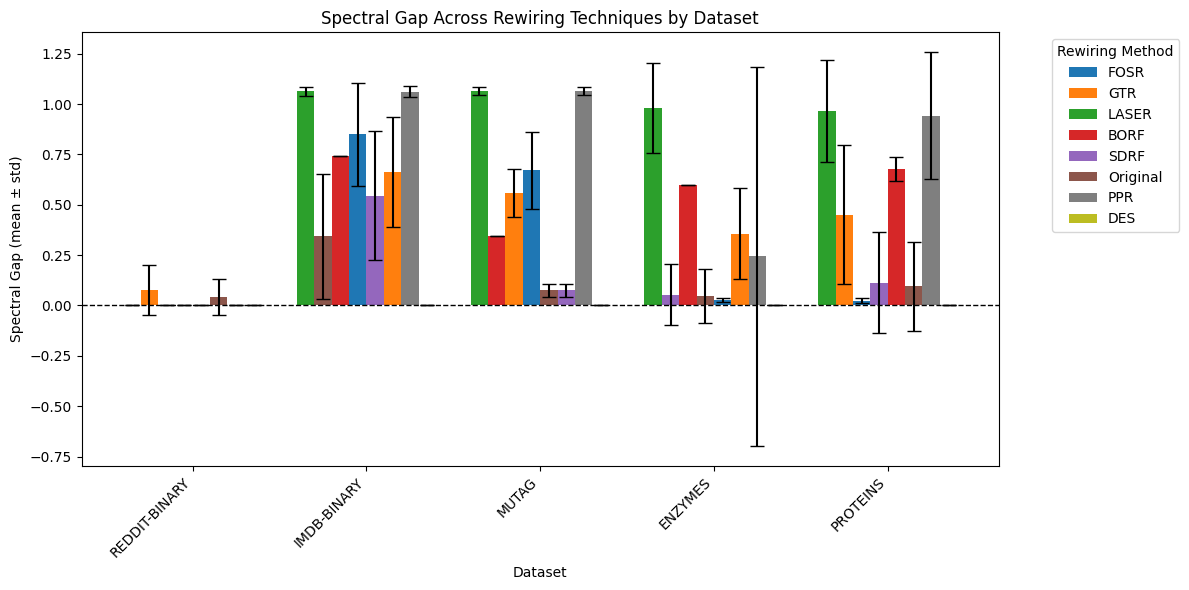

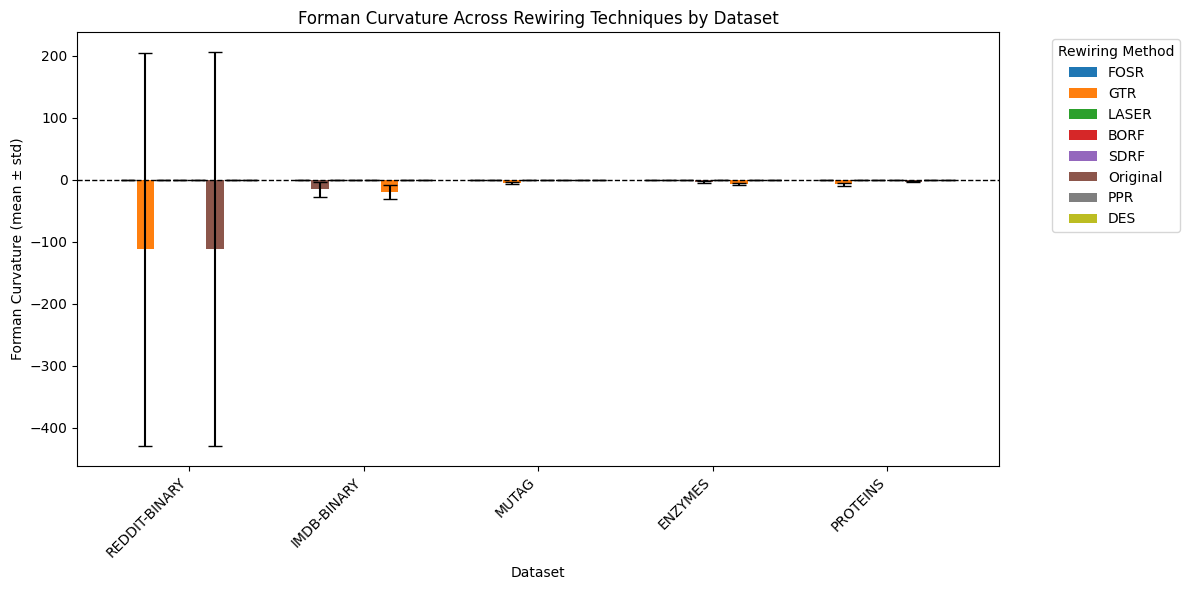

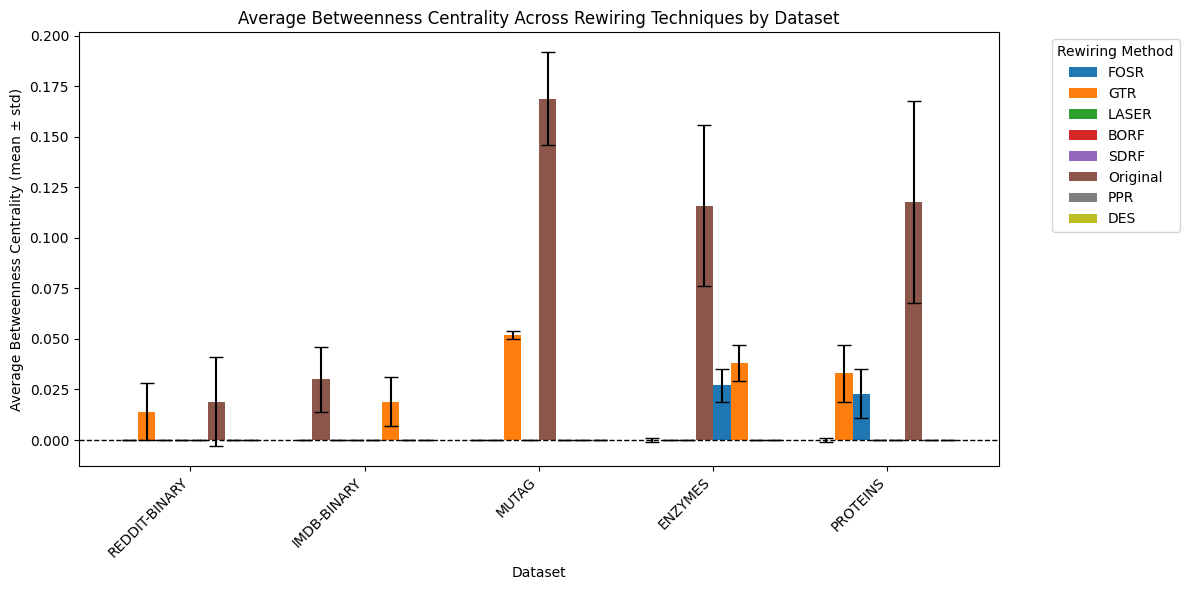

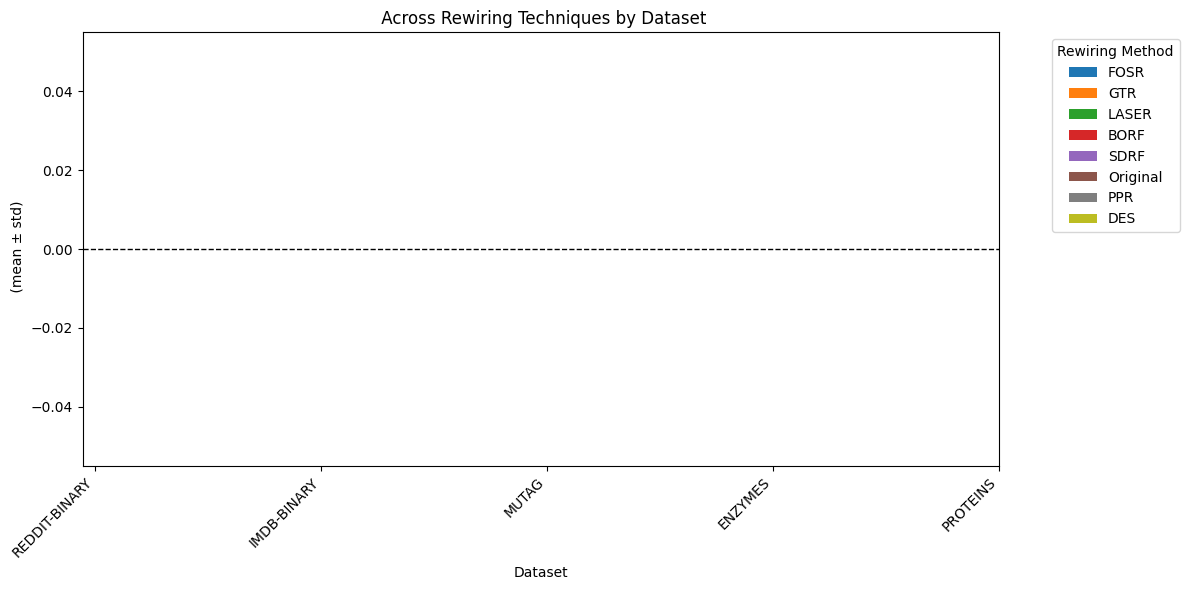

In [28]:
#NEW CELL SO I DONT BREAK ANYTHING
worksheet_data_specific = spreadsheet.worksheet_by_title("Dataset_Specific")

df = worksheet_data_specific.get_as_df()


# Rename columns for clarity
df.columns = ["Dataset", "Metric"] + df.iloc[0, 2:].tolist()
df = df[1:].reset_index(drop=True)

# **Forward fill dataset names BEFORE filtering**
df["Dataset"] = df["Dataset"].replace("", np.nan)  # Convert empty strings to NaN
df["Dataset"] = df["Dataset"].fillna(method="ffill")


# Remove extra spaces and newlines
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

for col in df.columns[2:]:
    # Split on '±' to get two parts: mean and std.
    # expand=True returns a DataFrame with two columns
    mean_std = df[col].str.split('±', expand=True)
    
    # Rename those columns appropriately
    df[col + "_mean"] = mean_std[0]  # left side of ±
    df[col + "_std"] = mean_std[1]   # right side of ±

    # Convert them to numeric (float). You can handle errors with 'coerce' if needed.
    df[col + "_mean"] = pd.to_numeric(df[col + "_mean"], errors='coerce')
    df[col + "_std"]  = pd.to_numeric(df[col + "_std"], errors='coerce')

metrics = df["Metric"].unique()

# Define fixed colors for rewiring methods
rewiring_colors = {
    "FOSR": "tab:blue",
    "GTR": "tab:orange",
    "LASER": "tab:green",
    "BORF": "tab:red",
    "SDRF": "tab:purple",
    "Original": "tab:brown",
    "DiffWire": "tab:pink",
    "PPR": "tab:gray",
    "DES": "tab:olive",
}

performance_order = {
    "REDDIT-BINARY": ["FOSR", "GTR", "LASER", "BORF", "SDRF", "Original", "DiffWire", "PPR", "DES"],
    "IMDB-BINARY": ["LASER", "Original", "BORF", "FOSR", "DiffWire", "SDRF", "GTR", "PPR", "DES"],
    "MUTAG": ["LASER", "BORF", "DiffWire", "GTR", "FOSR", "Original", "SDRF", "PPR", "DES"],
    "ENZYMES": ["LASER", "SDRF", "BORF", "Original", "FOSR", "DiffWire", "GTR", "PPR", "DES"],
    "PROTEINS": ["LASER", "DiffWire", "GTR", "FOSR", "SDRF", "BORF", "Original", "PPR", "DES"]
}

for metric in metrics:
    metric_df = df[df["Metric"] == metric].copy()
    
    if metric_df.empty:
        continue
    # Extract mean and std columns
    mean_cols = [c for c in metric_df.columns if c.endswith("_mean")]
    std_cols = [c.replace("_mean", "_std") for c in mean_cols]
    rewiring_methods = [c.replace("_mean", "") for c in mean_cols]

    # Convert columns to numeric, forcing errors to NaN for clean processing
    for col in mean_cols + std_cols:
        metric_df[col] = pd.to_numeric(metric_df[col], errors='coerce')

    # Drop rows that contains COLLAB
    metric_df = metric_df[~metric_df["Dataset"].str.contains("COLLAB")]

    # Ensure all values are numeric
    for col in mean_cols + std_cols:
        metric_df[col] = pd.to_numeric(metric_df[col], errors='coerce')

    fig, ax = plt.subplots(figsize=(12, 6))

    datasets = metric_df["Dataset"].unique()
    x = np.arange(len(datasets))  # Positions for dataset groups
    bar_width = 0.1  # Width of each bar

    for i, ds in enumerate(datasets):
    # Get the ordered rewiring methods for the dataset
        ordered_methods = performance_order[ds]

        #If metric is effective resistance and method is diffwire, remove diffwire since some values are unnaturally high
        if metric == "Effective Resistance" and "DiffWire" in ordered_methods:
            ordered_methods.remove("DiffWire")
        
        for j, rew in enumerate(ordered_methods):
            if rew not in metric_df.columns:  # Skip missing methods
                continue
            means = metric_df[metric_df["Dataset"] == ds][rew + "_mean"].values[0]
            stds = metric_df[metric_df["Dataset"] == ds][rew + "_std"].values[0]
            
            # Adjust x positions based on new ordering
            x_pos = x[i] + (j - len(ordered_methods) / 2) * bar_width + bar_width / 2
            ax.bar(x_pos, means, yerr=stds, width=bar_width, label=rew if i == 0 else "", color=rewiring_colors[rew], capsize=5)


    # Formatting
    ax.axhline(y=0, linestyle='dashed', color='black', linewidth=1)  # Dotted horizontal line at 0
    ax.set_xticks(x)
    ax.set_xticklabels(datasets, rotation=45, ha="right")
    ax.set_title(f"{metric} Across Rewiring Techniques by Dataset")
    ax.set_xlabel("Dataset")
    ax.set_ylabel(f"{metric} (mean ± std)")
    ax.legend(title="Rewiring Method", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()

Index(['Metric', 'Rewiring Technique', 'IMDB-BINARY', 'MUTAG', 'ENZYMES',
       'PROTEINS'],
      dtype='object')
Index(['ENZYMES', 'IMDB-BINARY', 'MUTAG', 'PROTEINS'], dtype='object')


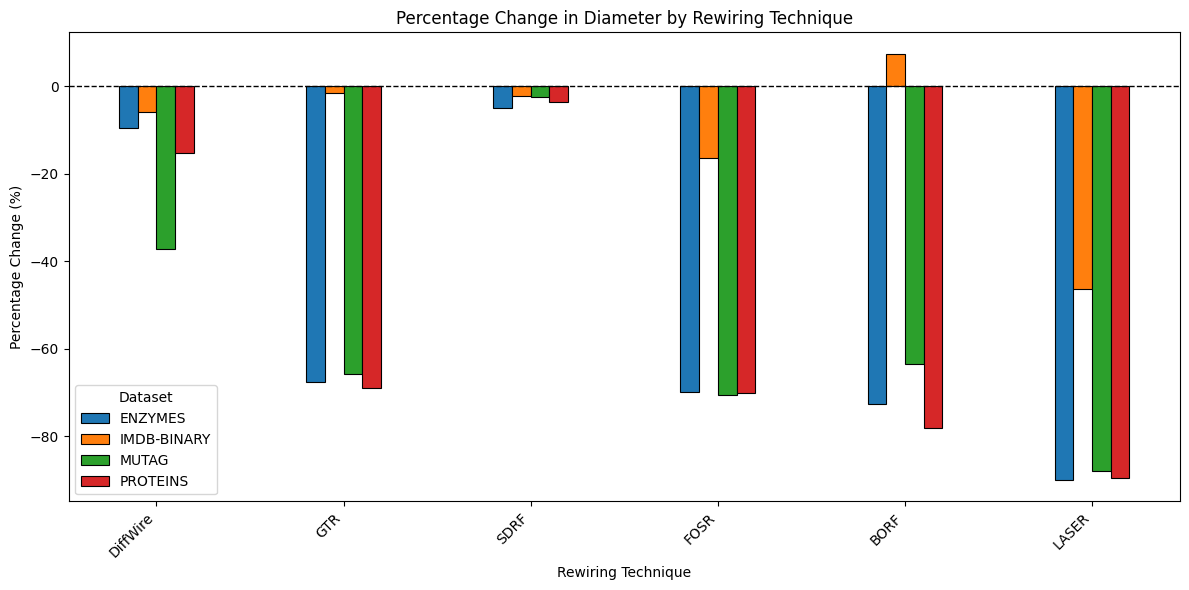

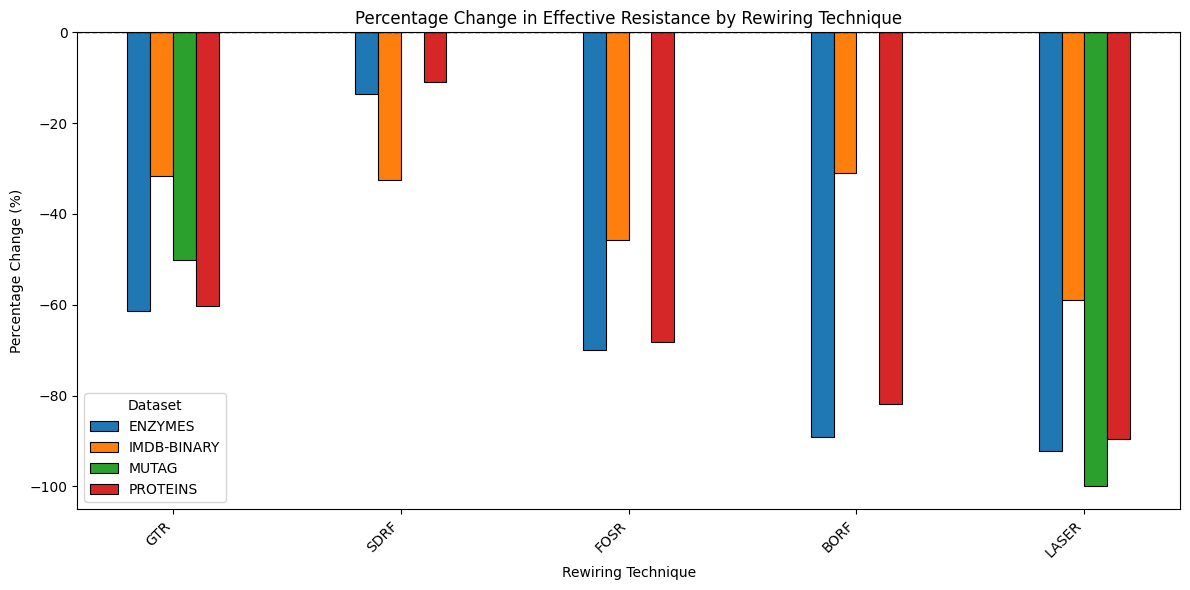

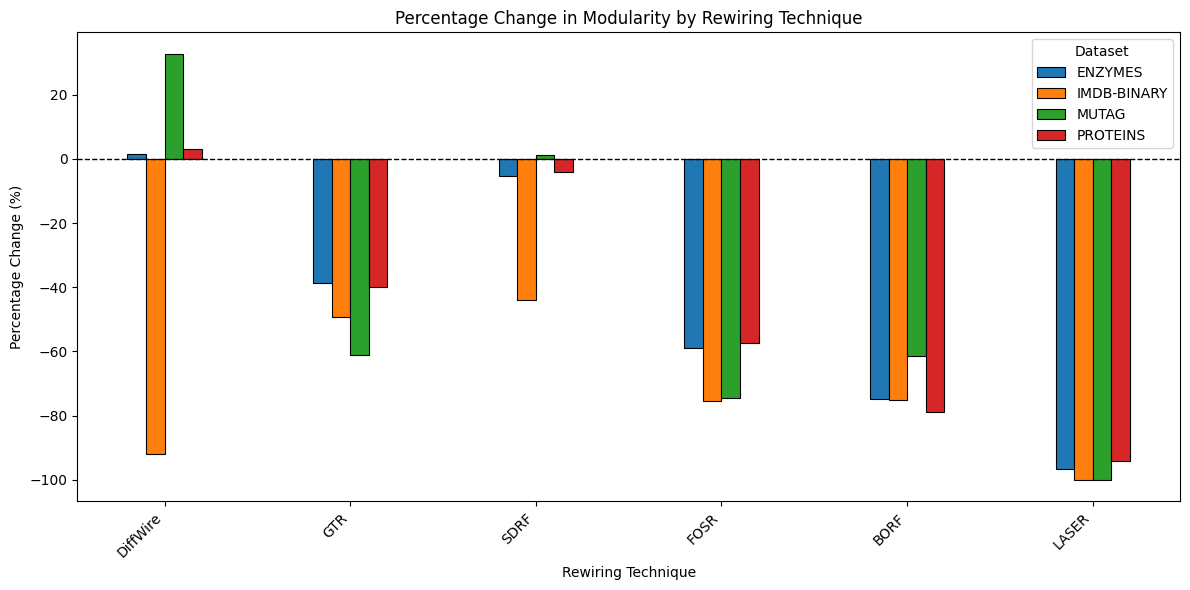

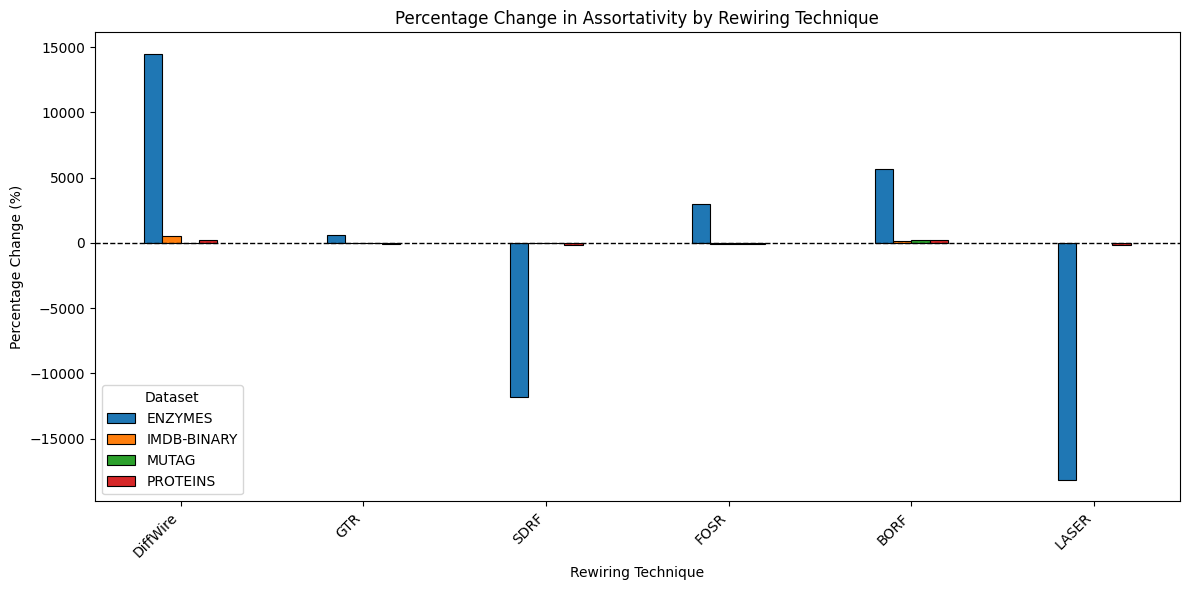

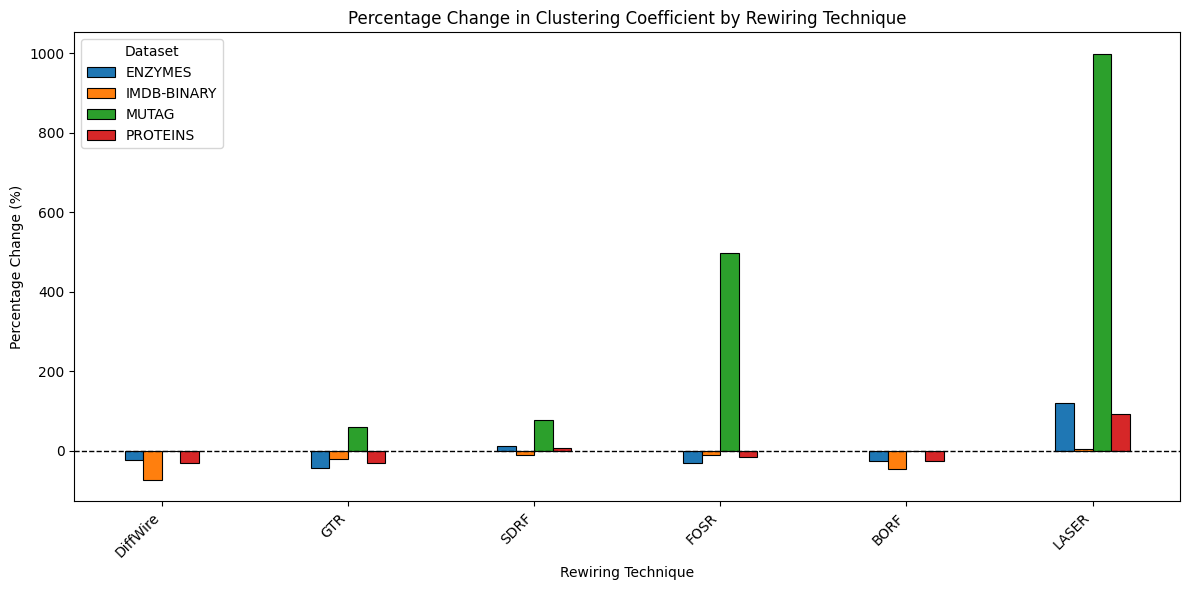

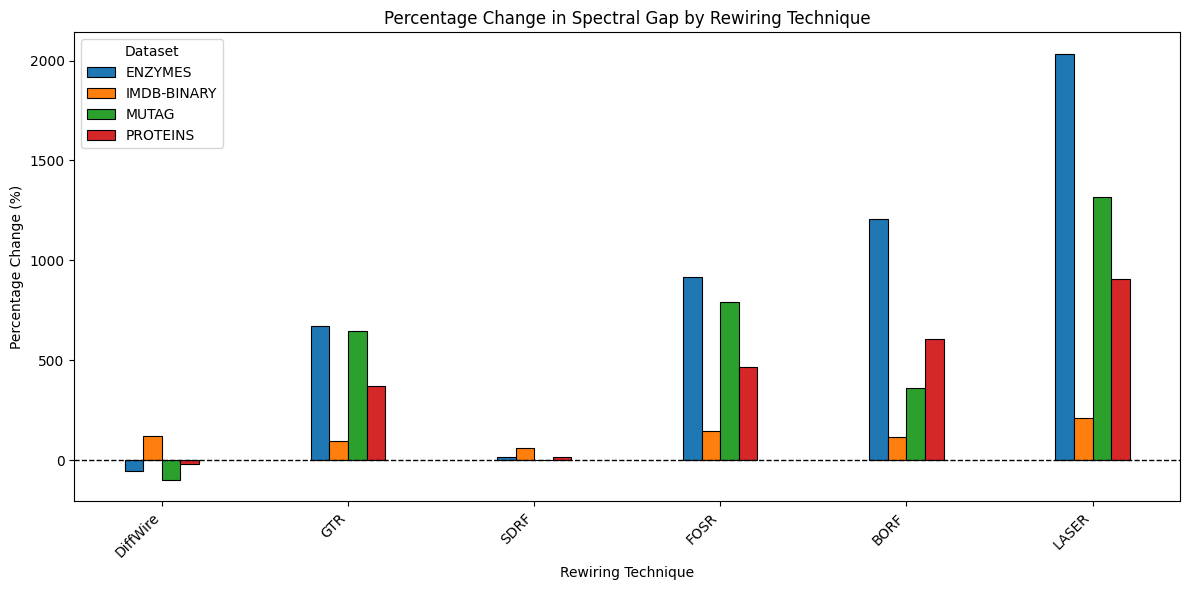

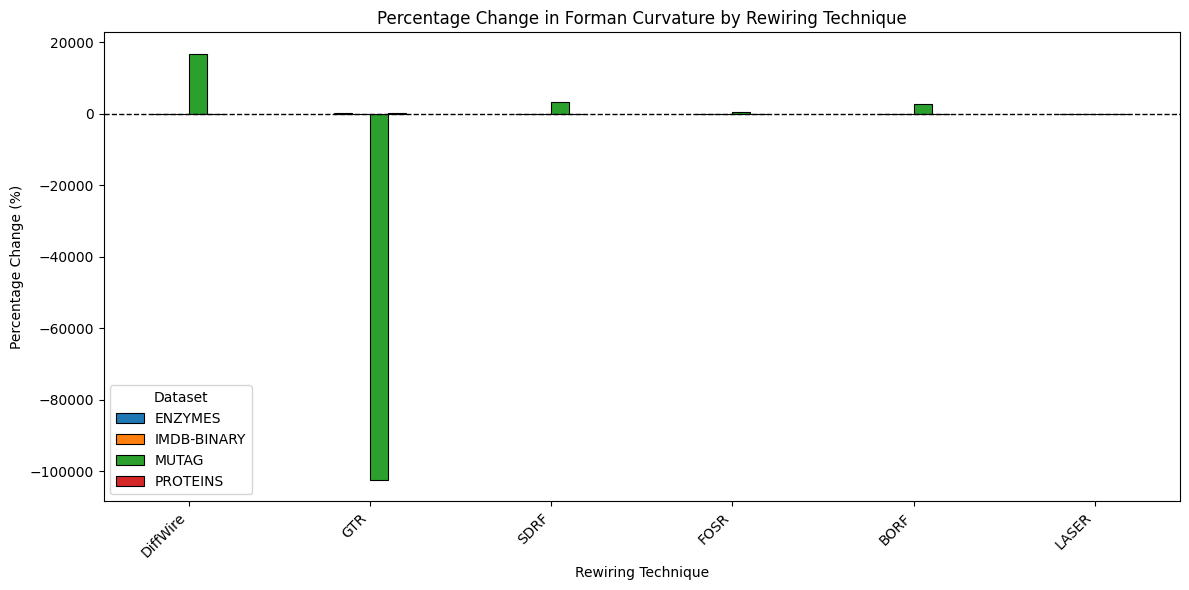

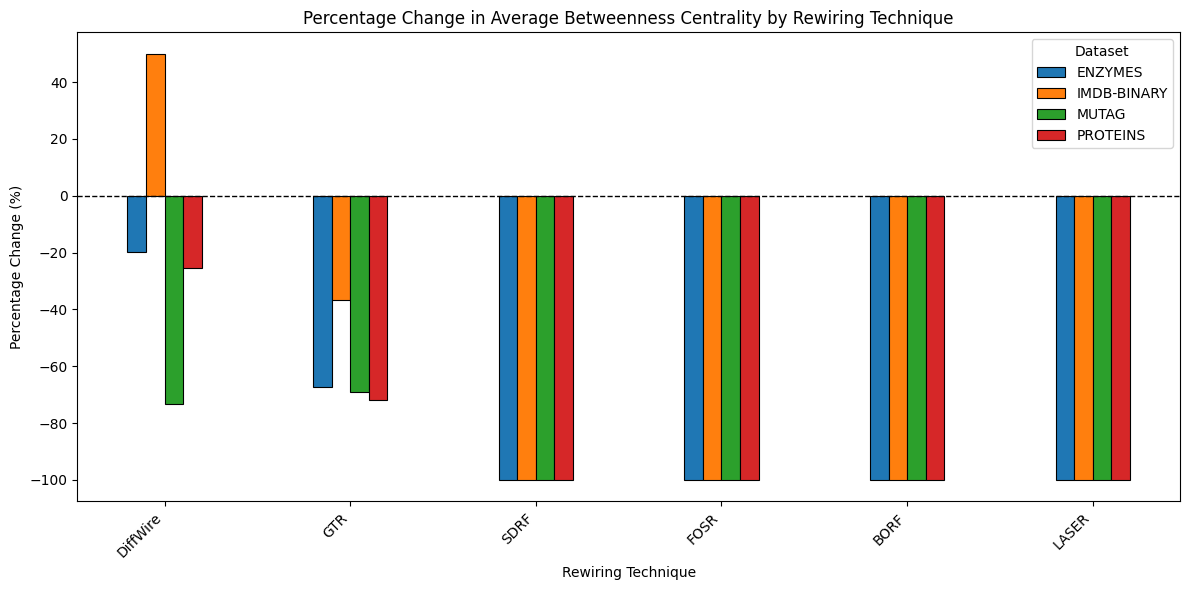

In [25]:
#Percent Change Plots 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

worksheet_percent_changed = spreadsheet.worksheet_by_title("Percent Change organized by Dataset")

df = worksheet_percent_changed.get_as_df()
print(df.columns)


# Identify dataset column names (all columns except "Metric" and "Rewiring Technique")
dataset_columns = df.columns.difference(["Metric", "Rewiring Technique"])
print(dataset_columns)

# Reshape the dataframe: Move dataset columns into a "Dataset" column
df = df.melt(id_vars=["Metric", "Rewiring Technique"], 
             value_vars=dataset_columns, 
             var_name="Dataset", 
             value_name="Percent Change")

#Convert Nan and to numeric
df["Percent Change"] = df["Percent Change"].replace(["N/A", "nan", ""], np.nan)
df["Percent Change"] = df["Percent Change"].astype(str).str.replace("%", "").astype(float)
df["Percent Change"] = pd.to_numeric(df["Percent Change"], errors='coerce')


metrics = df["Metric"].unique()  # Get unique metrics
bar_width = 0.1  # Width of each bar

for metric in metrics:
    metric_df = df[df["Metric"] == metric].copy()  # Filter for the current metric

    #Diffwire effective resistance change is ridiculous, so cutting that out for EF
    if metric == "Effective Resistance":
        metric_df = metric_df[metric_df["Rewiring Technique"] != "DiffWire"]

    fig, ax = plt.subplots(figsize=(12, 6))

    # Get unique rewiring techniques and dataset names
    rewiring_methods = metric_df["Rewiring Technique"].unique()
    datasets = metric_df["Dataset"].unique()

    x = np.arange(len(rewiring_methods))  # X positions for rewiring techniques

    
    for i, dataset in enumerate(datasets):
        subset = metric_df[metric_df["Dataset"] == dataset]  # Filter for dataset
        plt.bar(x + i * bar_width, subset["Percent Change"], width=bar_width, label=dataset, edgecolor="black", linewidth=0.8)

    ax.axhline(y=0, linestyle='dashed', color='black', linewidth=1)  # Dotted horizontal line at 0
    ax.set_xticks(x + (len(datasets) - 1) * bar_width / 2)
    ax.set_xticklabels(rewiring_methods, rotation=45, ha="right")
    ax.set_title(f"Percentage Change in {metric} by Rewiring Technique")
    ax.set_xlabel("Rewiring Technique")
    ax.set_ylabel("Percentage Change (%)")
    ax.legend(title="Dataset")

    plt.tight_layout()
    plt.show()
